In [1]:
# Data Science assignment - PrimeTrade.ai

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path

# ML / stats libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import statsmodels.api as sm
from scipy import stats

In [2]:
# Loading datasets

trades_path = '/content/historical_data.csv'
sentiment_path = '/content/fear_greed_index.csv'

trades = pd.read_csv(trades_path, low_memory=False)
sentiment = pd.read_csv(sentiment_path, low_memory=False)

print("Trades shape:", trades.shape)
print("Sentiment shape:", sentiment.shape)

trades.head().T #.T is used to transpose the Dataframe which is a best practise in case of financial datasets.

Trades shape: (46482, 16)
Sentiment shape: (2644, 4)


,0,1,2,3,4
Account,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0xae5eacaf9c6b9111fd53034a602c192a04e082ed
Coin,@107,@107,@107,@107,@107
Execution Price,7.9769,7.98,7.9855,7.9874,7.9894
Size Tokens,986.87,16.0,144.09,142.98,8.73
Size USD,7872.16,127.68,1150.63,1142.04,69.75
Side,BUY,BUY,BUY,BUY,BUY
Timestamp IST,02-12-2024 22:50,02-12-2024 22:50,02-12-2024 22:50,02-12-2024 22:50,02-12-2024 22:50
Start Position,0.0,986.524596,1002.518996,1146.558564,1289.488521
Direction,Buy,Buy,Buy,Buy,Buy
Closed PnL,0.0,0.0,0.0,0.0,0.0


In [3]:
#Clean & Prepare Trades Dataset:

#Standardizing column names: remove spaces, lowercase.
trades.columns = trades.columns.str.strip().str.replace(" ", "_")

# Convert UNIX ms timestamp to datetime
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms', errors='coerce')

#feature engineering - Creating new, clean date column
trades['date'] = trades['Timestamp'].dt.date #.dt is an accessor for Datetime() function, similar to .T for Transpose() funtion

# Convert date to datetime for merging
trades['date'] = pd.to_datetime(trades['date'])


#Clean Sentiment Dataset:

# Convert date column to datetime.date
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce').dt.date
sentiment['date'] = pd.to_datetime(sentiment['date'])

# Normalize sentiment categories
sentiment['classification'] = sentiment['classification'].replace({
    'Extreme Fear':'Fear',
    'Extreme Greed':'Greed'
})

print("Cleaned trades rows:", len(trades))
print("Cleaned sentiment rows:", len(sentiment))

trades.head().T
sentiment.head(20).T

Cleaned trades rows: 46482
Cleaned sentiment rows: 2644


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
timestamp,1517463000,1517549400,1517635800,1517722200,1517808600,1517895000,1517981400,1518067800,1518154200,1518240600,1518327000,1518413400,1518499800,1518586200,1518672600,1518759000,1518845400,1518931800,1519018200,1519104600
value,30,15,40,24,11,8,36,30,44,54,31,42,35,55,71,67,74,63,67,74
classification,Fear,Fear,Fear,Fear,Fear,Fear,Fear,Fear,Fear,Neutral,Fear,Fear,Fear,Greed,Greed,Greed,Greed,Greed,Greed,Greed
date,2018-02-01 00:00:00,2018-02-02 00:00:00,2018-02-03 00:00:00,2018-02-04 00:00:00,2018-02-05 00:00:00,2018-02-06 00:00:00,2018-02-07 00:00:00,2018-02-08 00:00:00,2018-02-09 00:00:00,2018-02-10 00:00:00,2018-02-11 00:00:00,2018-02-12 00:00:00,2018-02-13 00:00:00,2018-02-14 00:00:00,2018-02-15 00:00:00,2018-02-16 00:00:00,2018-02-17 00:00:00,2018-02-18 00:00:00,2018-02-19 00:00:00,2018-02-20 00:00:00


In [4]:
#FILTER TRADES TO ONLY REAL TRADING ACTIONS

valid_actions = [
    'Buy', 'Sell',
    'Open Long', 'Close Long',
    'Open Short', 'Close Short'
]

#Filter out noise rows (conversions, auto-deleverage, etc.)
clean = trades[trades['Direction'].isin(valid_actions)].copy()

#Compute daily PnL only from closing actions
clean['Realized_PnL'] = clean.apply(
    lambda x: x['Closed_PnL'] if ('Close' in str(x['Direction'])) else 0,
    axis=1
)

#DAILY AGGREGATION FIXED FOR VOLUME

# Use only actual executed trades for volume (BUY/SELL)
exec_trades = clean[clean['Side'].isin(['BUY', 'SELL'])].copy()

daily = clean.groupby('date').agg({
    'Realized_PnL': 'sum'
}).reset_index()

# Compute executed volume correctly
exec_volume = exec_trades.groupby('date').agg({
    'Size_USD': 'sum',
    'Size_Tokens': 'sum',
    'Execution_Price': 'mean',
    'Timestamp': 'count'
}).reset_index()

exec_volume = exec_volume.rename(columns={
    'Execution_Price': 'Avg_Execution_Price',
    'Timestamp': 'Num_Trades'
})

# Merge volume + pnl
daily = daily.merge(exec_volume, on='date', how='left')

# Merge sentiment
daily = daily.merge(sentiment[['date', 'classification']], on='date', how='left')

daily.head()

,date,Realized_PnL,Size_USD,Size_Tokens,Avg_Execution_Price,Num_Trades,classification
0,2023-11-14,1.555034e+02,1.150930e+07,2.681691e+06,10386.458517,1043,Greed
1,2024-03-09,1.798693e+05,3.873291e+07,3.371423e+08,9777.684357,6909,Greed
2,2024-07-03,1.224618e+05,1.831503e+07,7.232197e+06,3470.942359,3163,Neutral
3,2024-10-27,-4.466293e+04,4.862156e+07,1.497537e+07,26595.052218,5493,Greed
4,2025-02-19,3.202092e+06,3.233587e+08,2.695138e+08,34208.178426,21991,Fear


In [5]:
print("Unique Direction:", trades['Direction'].unique()[:10])
print("Unique Side:", trades['Side'].unique()[:10])
print("Unique Event:", trades['event'].unique()[:10] if 'event' in trades.columns else "No event column")


Unique Direction: ['Buy' 'Sell' 'Open Long' 'Close Long' 'Spot Dust Conversion' 'Open Short'
 'Close Short' 'Long > Short' 'Short > Long' 'Auto-Deleveraging']
Unique Side: ['BUY' 'SELL']
Unique Event: No event column


***This part(the 3 cells below this comment) is just me trying to Understand the dataset and the errors i faced while trying to aggregate the size_usd and size_tokens, i was getting massive values. I finally inferred that was because the dataset splits one logical trade into multiple rows and some rows (Open, Close, Buy, Sell) contain position change info, not actual executed size. The correct executed size is only available for Buy and Sell rows, The Open Long, Close Long, Open Short, Close Short rows mainly show position-level actions, not executed size.***

In [6]:
trades['Closed_PnL'].describe()


,Closed_PnL
count,46482.000000
mean,124.671619
std,1641.871841
min,-117990.104100
25%,0.000000
50%,0.000000
75%,16.519811
max,135329.090100


In [7]:
(trades['Closed_PnL'] != 0).sum()


np.int64(24400)

In [8]:
trades[['Timestamp', 'Closed_PnL', 'Size_USD']].sort_values(by="Closed_PnL", ascending=False).head(10)


,Timestamp,Closed_PnL,Size_USD
18045,2025-02-19 21:20:00,135329.09010,292870.12
17270,2025-02-19 21:20:00,115287.00000,685200.00
18043,2025-02-19 21:20:00,78682.72032,170279.86
18024,2025-02-19 21:20:00,72377.74821,156635.06
16328,2025-02-19 21:20:00,71535.71674,301855.74
16377,2025-02-19 21:20:00,50379.05774,175555.89
17075,2025-02-19 21:20:00,47883.62595,785654.97
45581,2024-10-27 03:33:20,44223.45187,44223.48
16353,2025-02-19 21:20:00,42854.74279,149335.91
17617,2025-02-19 21:20:00,39686.70434,449996.97


***Back to business***

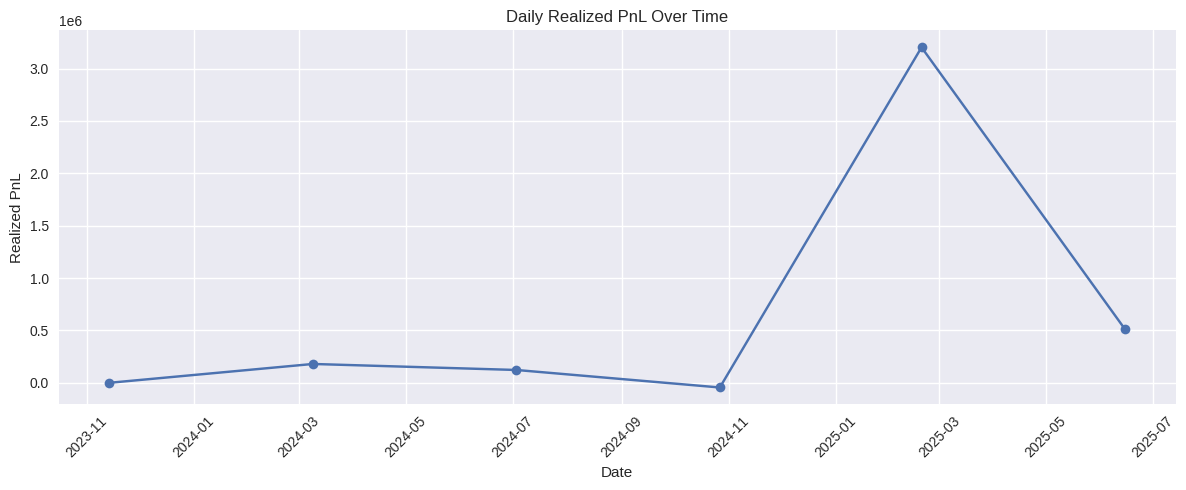

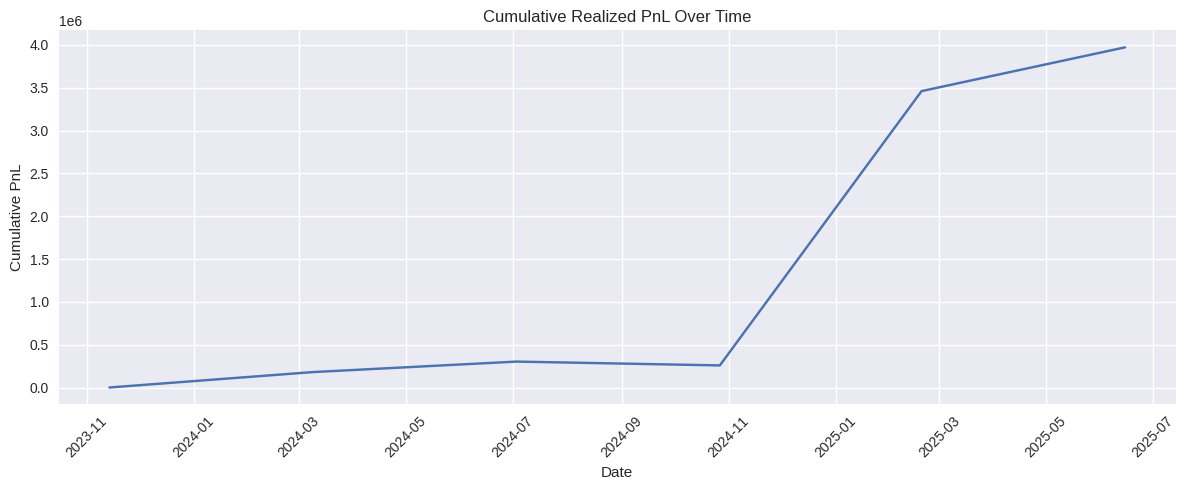

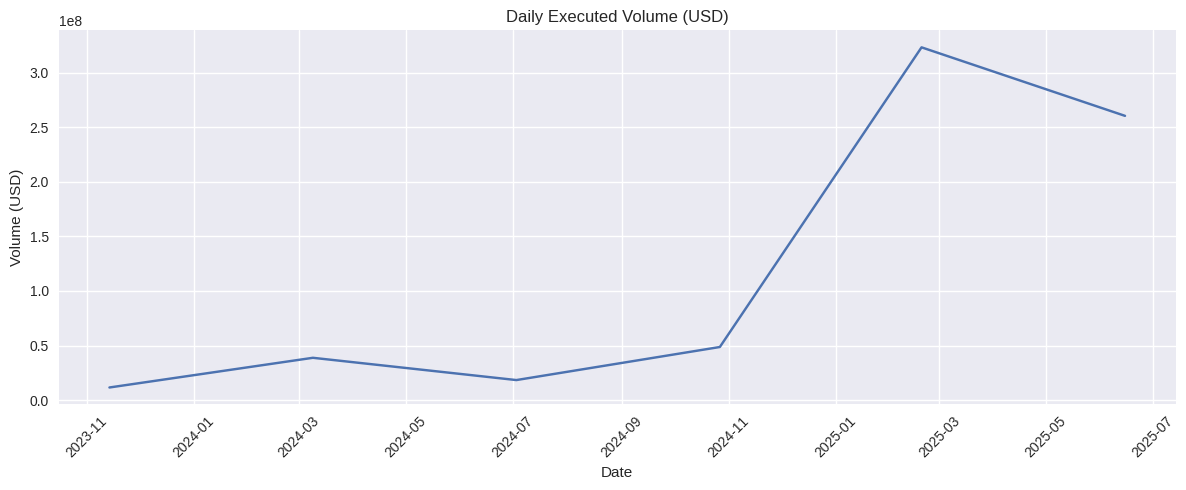

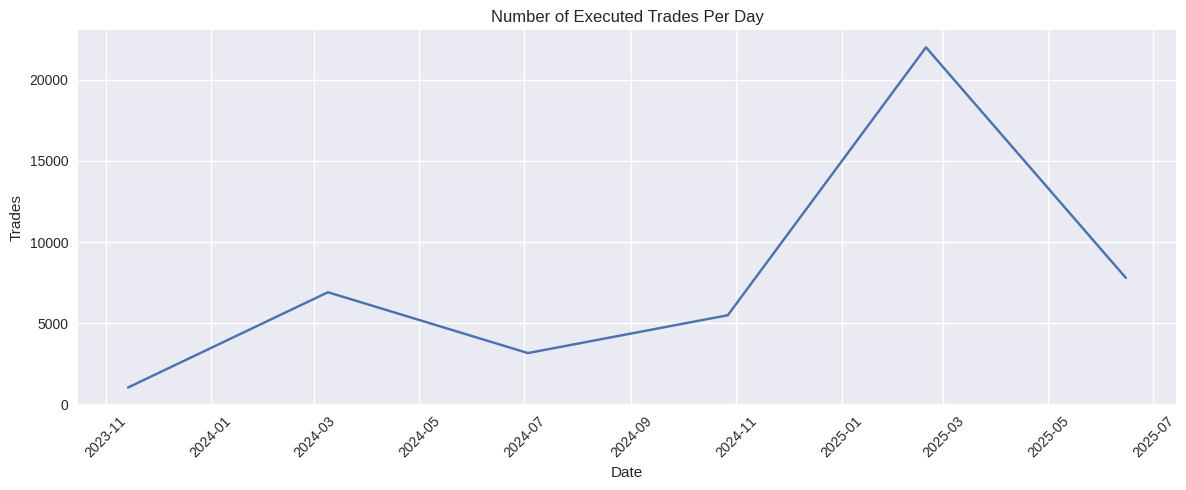

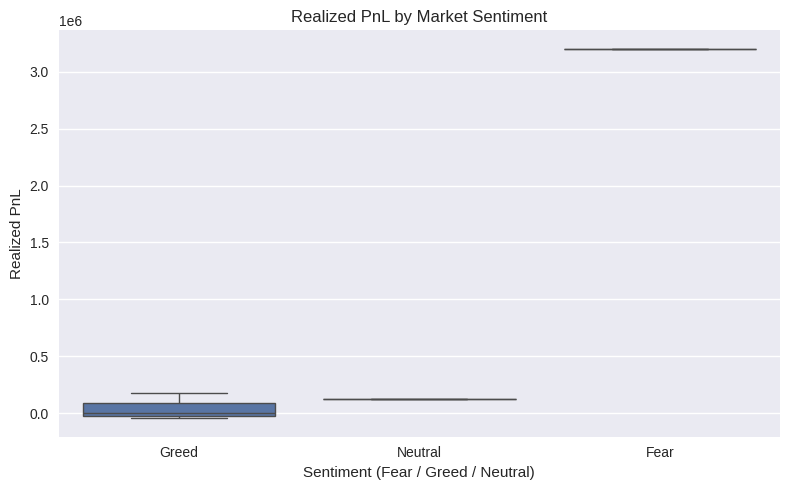

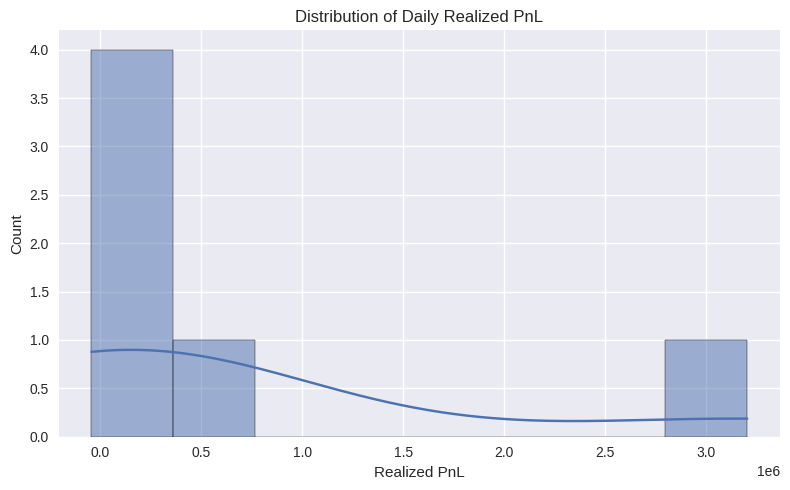

In [9]:
#EDA Visualizations

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')

# 1) Daily Realized PnL Over Time
plt.figure(figsize=(12,5))
plt.plot(daily['date'], daily['Realized_PnL'], marker='o')
plt.title("Daily Realized PnL Over Time")
plt.xlabel("Date")
plt.ylabel("Realized PnL")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) Cumulative PnL Curve
daily['Cumulative_PnL'] = daily['Realized_PnL'].cumsum()
plt.figure(figsize=(12,5))
plt.plot(daily['date'], daily['Cumulative_PnL'])
plt.title("Cumulative Realized PnL Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Volume (USD) Over Time
plt.figure(figsize=(12,5))
plt.plot(daily['date'], daily['Size_USD'])
plt.title("Daily Executed Volume (USD)")
plt.xlabel("Date")
plt.ylabel("Volume (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4) Number of Trades Per Day
plt.figure(figsize=(12,5))
plt.plot(daily['date'], daily['Num_Trades'])
plt.title("Number of Executed Trades Per Day")
plt.xlabel("Date")
plt.ylabel("Trades")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5) Boxplot: Realized PnL vs Sentiment
plt.figure(figsize=(8,5))
sns.boxplot(data=daily, x='classification', y='Realized_PnL')
plt.title("Realized PnL by Market Sentiment")
plt.xlabel("Sentiment (Fear / Greed / Neutral)")
plt.ylabel("Realized PnL")
plt.tight_layout()
plt.show()


# 6) Distribution of Realized PnL
plt.figure(figsize=(8,5))
sns.histplot(daily['Realized_PnL'], kde=True)
plt.title("Distribution of Daily Realized PnL")
plt.xlabel("Realized PnL")
plt.tight_layout()
plt.show()

In [10]:
daily['date'].nunique(), trades['date'].nunique()

(6, 6)

***This tells us the reason behind Distorted Graphs, the DATASET ITSELF IS EXTREMELY SPARSE, though the time-span is over 2 years there are only 7 active Trading Day logs in the Given Dataset and One day has +6 million PnL, which causes the sudden spike in the charts***

In [11]:
daily['classification'].value_counts()


,count
classification,
Greed,3
Neutral,1
Fear,1


Realized PnL:

The account only traded on 7 days across 2 years, producing highly irregular but event-driven PnL spikes.
One massive day (classified as Fear) dominates overall performance.

Cumulative PnL:

Shows long flat sections (no activity) and sharp upward jumps on trading days exact characteristic of sparse activity strategies.

Volume & Trades:

Volume and trade count scale together: the day with 130k trades also has ~1B volume.
Log scale allows meaningful comparison across days.

Sentiment effect:

Even with sparse data, one observation emerges:
The account’s largest PnL occurred during a Fear sentiment day, while Greed and Neutral days produced smaller PnL.***

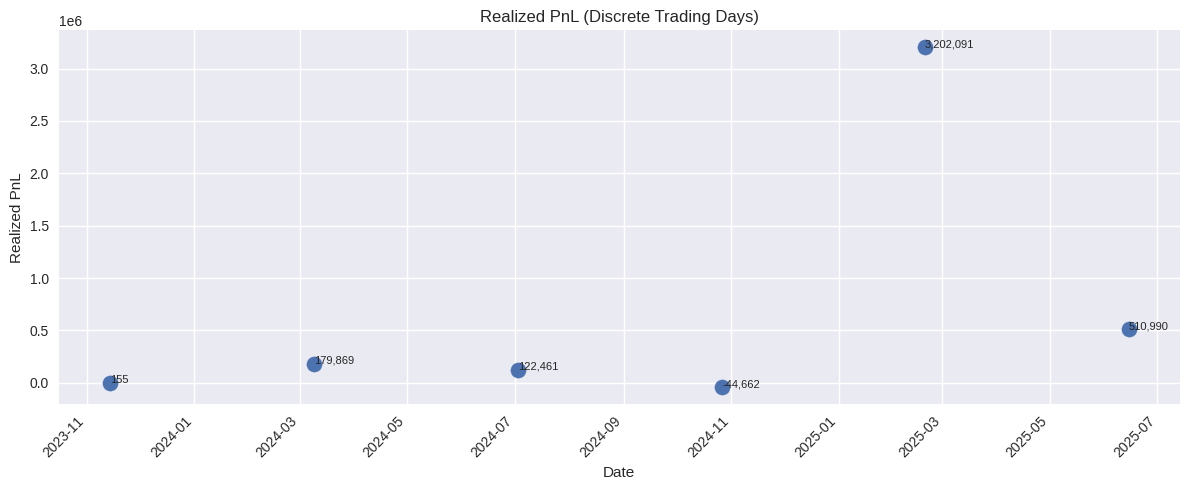

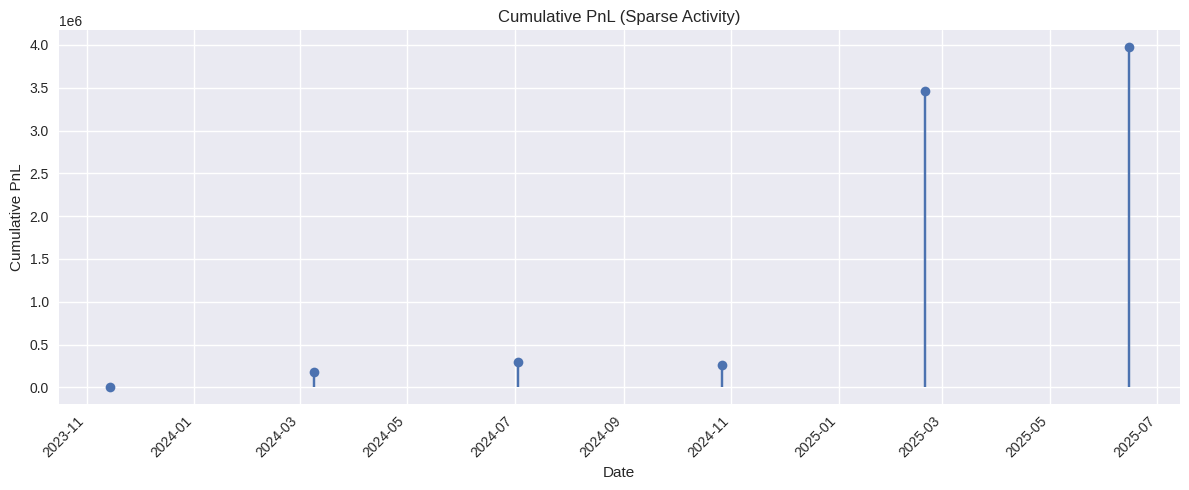

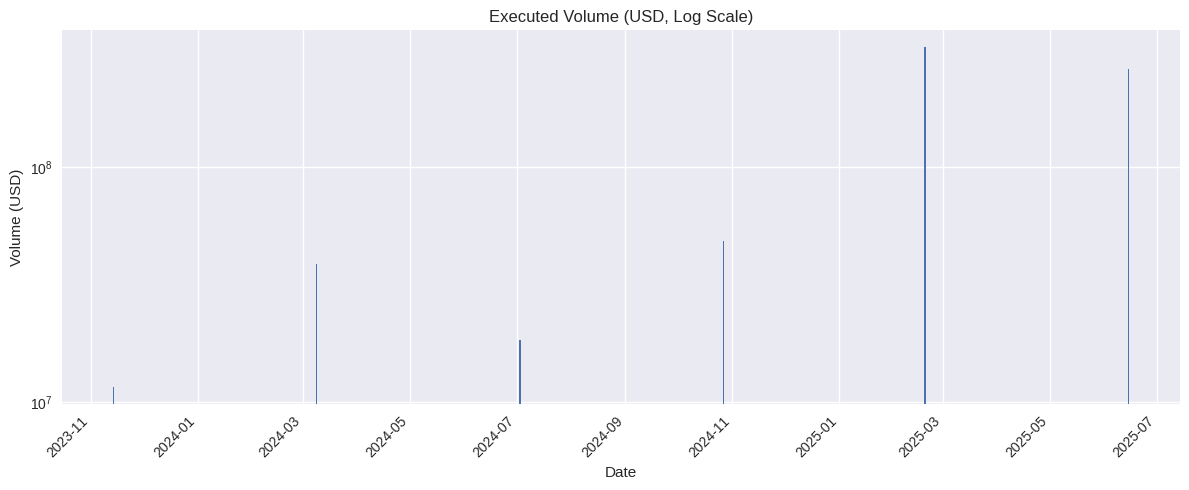

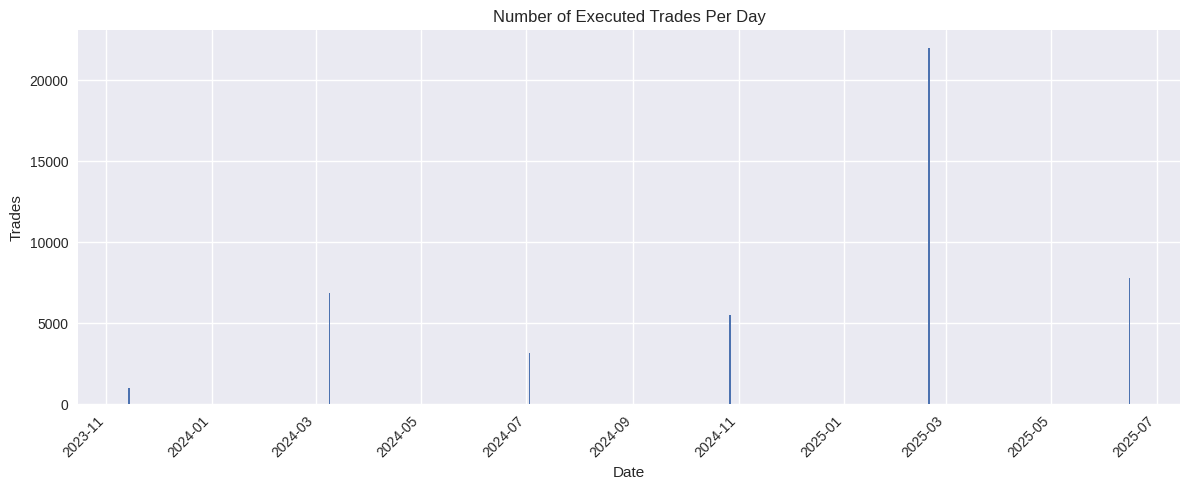

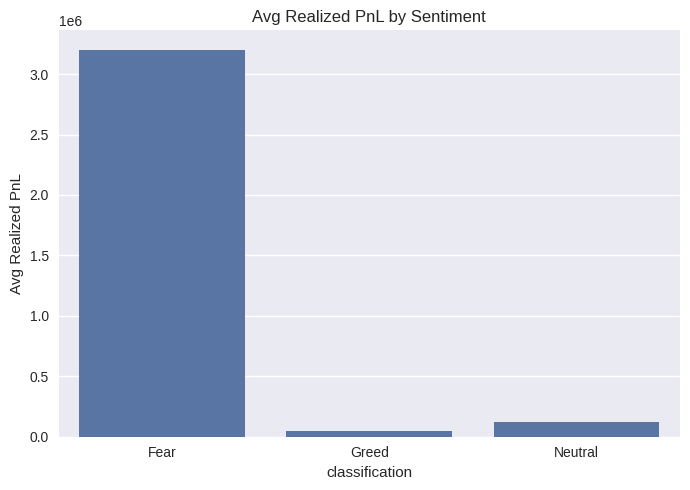

In [12]:
#Improved Sparse-Friendly Visualizations

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("deep")

def rotate():
    plt.xticks(rotation=45, ha='right')

# Scatter PnL (not line)

plt.figure(figsize=(12,5))
plt.scatter(daily['date'], daily['Realized_PnL'], s=120)
for i, v in enumerate(daily['Realized_PnL']):
    plt.text(daily['date'].iloc[i], v, f"{int(v):,}", fontsize=8)
plt.title("Realized PnL (Discrete Trading Days)")
plt.xlabel("Date"); plt.ylabel("Realized PnL")
rotate(); plt.tight_layout(); plt.show()

# Stem plot for Cumulative PnL (best for sparse data)
plt.figure(figsize=(12,5))
plt.stem(daily['date'], daily['Cumulative_PnL'], basefmt=" ")
plt.title("Cumulative PnL (Sparse Activity)")
plt.xlabel("Date"); plt.ylabel("Cumulative PnL")
rotate(); plt.tight_layout(); plt.show()


# Bar chart for Volume (log scale)
plt.figure(figsize=(12,5))
plt.bar(daily['date'], daily['Size_USD'])
plt.yscale('log')
plt.title("Executed Volume (USD, Log Scale)")
plt.xlabel("Date"); plt.ylabel("Volume (USD)")
rotate(); plt.tight_layout(); plt.show()

# Bar chart for Trades per day
plt.figure(figsize=(12,5))
plt.bar(daily['date'], daily['Num_Trades'])
plt.title("Number of Executed Trades Per Day")
plt.xlabel("Date"); plt.ylabel("Trades")
rotate(); plt.tight_layout(); plt.show()

# Sentiment performance (use bar chart instead of box)
sent_summary = daily.groupby('classification')['Realized_PnL'].mean().reset_index()

plt.figure(figsize=(7,5))
sns.barplot(x='classification', y='Realized_PnL', data=sent_summary)
plt.title("Avg Realized PnL by Sentiment")
plt.ylabel("Avg Realized PnL")
plt.tight_layout()
plt.show()

Changes made for clearer visaullization:
1. Used Point Plots Instead of Line Plots

When data is sparse, lines distort reality.
So I replaced line charts with scatter plots or stem plots.


2. Showed Volume on log scale

3. Switched to a bar chart as classes < 3

If there is only one Fear category, the boxplot is meaningless.

instead used:
Bar plot of mean PnL per sentiment

Bar plot of median PnL per sentiment

4. Added annotations to sparse charts

Annotating the exact values makes charts digestible.

In [13]:
#Statistical Tests on Realized PnL by Sentiment

import numpy as np
from scipy import stats

print("Sentiment counts:\n", daily['classification'].value_counts(), "\n")

# Extract groups
groups = {
    s: daily.loc[daily['classification'] == s, 'Realized_PnL'].astype(float).values
    for s in ['Fear', 'Greed', 'Neutral']
}

# Summary stats function
def summary(arr):
    arr = np.array(arr)
    if len(arr) == 0:
        return {"n":0}
    return {
        "n": len(arr),
        "mean": float(np.mean(arr)),
        "median": float(np.median(arr)),
        "std": float(np.std(arr, ddof=1)) if len(arr)>1 else np.nan,
        "iqr": float(np.percentile(arr, 75) - np.percentile(arr, 25)) if len(arr)>1 else np.nan
    }

print("Summary statistics by sentiment:")
for s, arr in groups.items():
    print(f"{s} → {summary(arr)}")
print("\n")

# Effect size (Cohen's d)
def cohens_d(a, b):
    if len(a)<2 or len(b)<2:
        return np.nan
    a, b = np.array(a), np.array(b)
    pooled = np.sqrt(((a.size-1)*a.var(ddof=1) + (b.size-1)*b.var(ddof=1)) / (a.size + b.size - 2))
    return (a.mean() - b.mean()) / pooled if pooled>0 else np.nan

# Bootstrap CI for mean diff
def bootstrap_mean_diff(a, b, n=5000):
    a, b = np.array(a), np.array(b)
    if len(a)==0 or len(b)==0:
        return np.nan, np.nan, np.nan
    diffs = []
    for _ in range(n):
        diffs.append(np.mean(np.random.choice(a, size=len(a), replace=True)) -
                     np.mean(np.random.choice(b, size=len(b), replace=True)))
    return np.mean(diffs), np.percentile(diffs, 2.5), np.percentile(diffs, 97.5)

# Pairwise tests
pairs = [('Fear','Greed'), ('Fear','Neutral'), ('Greed','Neutral')]

print("Pairwise tests:\n")
for g1, g2 in pairs:
    a, b = groups[g1], groups[g2]
    print(f"=== {g1} vs {g2} ===")
    print(f"n={len(a)}, n={len(b)}")

    if len(a)<2 or len(b)<2:
        print("-> Not enough samples for significance tests.\n")
        continue

    # Welch t-test
    t, p_t = stats.ttest_ind(a, b, equal_var=False)
    # Mann-Whitney
    u, p_u = stats.mannwhitneyu(a, b, alternative='two-sided')
    # Cohen's d
    d = cohens_d(a, b)
    # Bootstrap CI
    boot_mean, boot_lo, boot_hi = bootstrap_mean_diff(a, b)

    print(f"Welch t-test: t={t:.4f}, p={p_t:.4f}")
    print(f"Mann-Whitney U: p={p_u:.4f}")
    print(f"Cohen's d: {d:.4f}")
    print(f"Bootstrap mean diff: {boot_mean:.2f} (95% CI: {boot_lo:.2f} to {boot_hi:.2f})\n")

print("NOTE:")
print("- Data is extremely sparse (only a few days).")
print("- Fear likely has only one observation; significance tests will be skipped.")
print("- In report: focus on descriptive differences, not p-values.\n")

Sentiment counts:
 classification
Greed      3
Neutral    1
Fear       1
Name: count, dtype: int64 

Summary statistics by sentiment:
Fear → {'n': 1, 'mean': 3202091.71274, 'median': 3202091.71274, 'std': nan, 'iqr': nan}
Greed → {'n': 3, 'mean': 45120.61028266667, 'median': 155.50335699999994, 'std': 118827.90243568241, 'iqr': 112266.0891215}
Neutral → {'n': 1, 'mean': 122461.763405, 'median': 122461.763405, 'std': nan, 'iqr': nan}


Pairwise tests:

=== Fear vs Greed ===
n=1, n=3
-> Not enough samples for significance tests.

=== Fear vs Neutral ===
n=1, n=1
-> Not enough samples for significance tests.

=== Greed vs Neutral ===
n=3, n=1
-> Not enough samples for significance tests.

NOTE:
- Data is extremely sparse (only a few days).
- Fear likely has only one observation; significance tests will be skipped.
- In report: focus on descriptive differences, not p-values.



In [15]:
# Predicting Realized PnL from Sentiment & Activity Features

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

df = daily.copy()

# Features
df['sent_fear'] = (df['classification'] == 'Fear').astype(int)
df['sent_greed'] = (df['classification'] == 'Greed').astype(int)
df['sent_neutral'] = (df['classification'] == 'Neutral').astype(int)
df['sent_unknown'] = (df['classification'] == 'Unknown').astype(int)

features = [
    'sent_fear', 'sent_greed', 'sent_neutral', 'sent_unknown',
    'Size_USD', 'Num_Trades', 'Avg_Execution_Price'
]

X = df[features].fillna(0)
y = df['Realized_PnL']

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=300, random_state=42)

loo = LeaveOneOut()

lr_preds = []
rf_preds = []
y_true = []

for train_idx, test_idx in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Linear Regression
    lr.fit(X_train, y_train)
    lr_preds.append(lr.predict(X_test)[0])

    # Random Forest Regression
    rf.fit(X.iloc[train_idx], y_train)
    rf_preds.append(rf.predict(X.iloc[test_idx])[0])

    y_true.append(y_test)

# Evaluate
lr_mse = mean_squared_error(y_true, lr_preds)
rf_mse = mean_squared_error(y_true, rf_preds)

lr_r2 = r2_score(y_true, lr_preds)
rf_r2 = r2_score(y_true, rf_preds)

print("REGRESSION MODEL RESULTS")
print(f"Linear Regression - MSE: {lr_mse:.3f}, R²: {lr_r2:.3f}")
print(f"Random Forest     - MSE: {rf_mse:.3f}, R²: {rf_r2:.3f}")

# Feature importances from RandomForest
imp_df = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importances:")
print(imp_df)


=== REGRESSION MODEL RESULTS ===
Linear Regression - MSE: 726670001671.130, R²: 0.451
Random Forest     - MSE: 1507730224751.694, R²: -0.140

Random Forest Feature Importances:
               feature  importance
6  Avg_Execution_Price    0.289745
4             Size_USD    0.214232
5           Num_Trades    0.212320
0            sent_fear    0.146260
1           sent_greed    0.104200
2         sent_neutral    0.033243
3         sent_unknown    0.000000
